In [1]:
%matplotlib inline
import helpers as hp
import numpy as np
import os
import validation as vld
from sklearn import linear_model, neighbors
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import mask_to_submission as mts
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, downscale_local_mean, hough_line, hough_ellipse)
from skimage.feature import canny
from skimage import data
from skimage.draw import line
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from skimage.morphology import dilation

In [2]:
# load training pictures
root_dir = 'data/train/'
image_dir = root_dir + 'images/'
img_files = os.listdir(image_dir)
images = [hp.load_image(image_dir + img_files[i]) for i in range(len(img_files))]

gt_dir = root_dir + 'groundtruth/'
gt_files = os.listdir(gt_dir)
gt_imgs = [hp.load_image(gt_dir + gt_files[i]) for i in range(len(gt_files))]

In [3]:
# generate features for every image
X = np.empty([0,6])
Y = np.empty([0])
Y_pix = np.empty([0])
train_n = 100
patch_size = 4;

#iterate through all images in the train data set
for n in range(train_n):
    img_patches = hp.img_crop(images[n], patch_size, patch_size)
    gt_patches = hp.img_crop(gt_imgs[n], patch_size, patch_size)
    gt_pixels = hp.img_crop(gt_imgs[n], 1, 1)

    Xn = np.asarray([hp.extract_features(img_patches[i]) for i in range(len(img_patches))])
    Yn = np.asanyarray([hp.classify_binary_blob(gt_patches[i],0.5) for i in range(len(gt_patches))])
    Yn_pix = np.asanyarray([hp.classify_binary_blob(gt_pixels[i],1) for i in range(len(gt_pixels))])
    X = np.vstack((X, Xn))
    Y = np.append(Y, Yn)
    Y_pix = np.append(Y_pix, Yn_pix)

In [4]:
print(X.shape)
print(Y.shape)
print(Y_pix.shape)

print(X[1010])

(1000000, 6)
(1000000,)
(16000000,)
[ 0.51960778  0.48676476  0.43504903  0.00979239  0.00936347  0.00681559]


In [5]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3, p = 1)
knn.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='uniform')

In [6]:
Z = knn.predict(X)
print(vld.patchBasedCorrectness(Z, Y))
#print(vld.pixelBasedCorrectness(Z, Y_pix, patch_size))

(232032, 147966, 0.6376965246172942, 45516, 0.19616259826230864)


data/test/test_33/test_33.png
(608, 608, 3)
1858 (23104,)


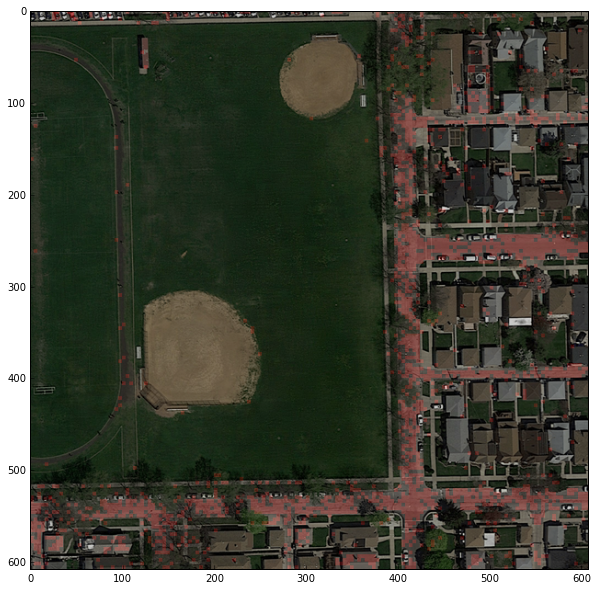

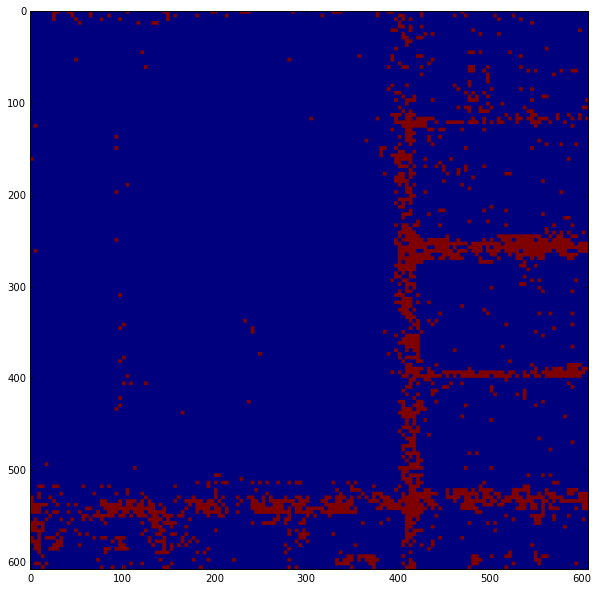

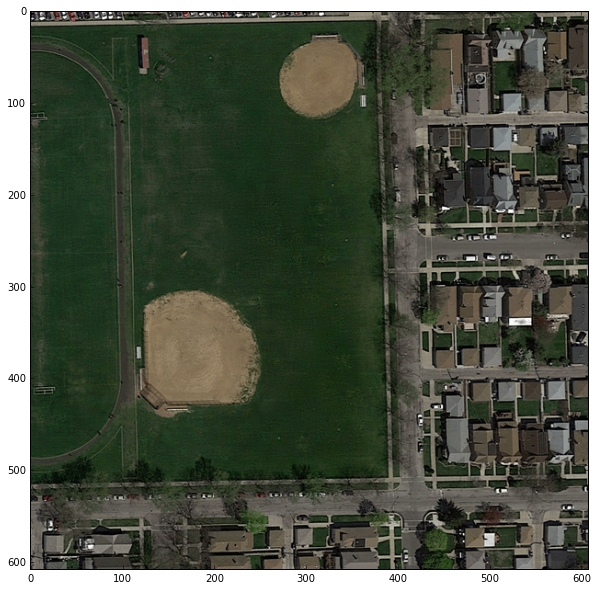

In [110]:
# compute correct predictions rate on the test set
#load test example
test_idx = 33
test_image_name = 'data/test/test_' + '%.1d' % test_idx + '/test_' +  '%.1d' % test_idx  + '.png'

#create features for a test image
test_image = hp.load_image(test_image_name)
test_img_patches = hp.img_crop(test_image, patch_size, patch_size)
Xt = np.asarray([hp.extract_features(test_img_patches[i]) for i in range(len(test_img_patches))])
#evaluate predictions and create a mask
print(test_image_name)
Zt = knn.predict(Xt)
prediction_mask = hp.label_to_img(test_image.shape[0], test_image.shape[1], patch_size, patch_size, Zt)
print(test_image.shape)
prediction_overlay = hp.make_img_overlay(test_image, prediction_mask)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_overlay)
plt.figure(figsize=(10, 10))
plt.imshow(prediction_mask)
plt.figure(figsize=(10, 10))
plt.imshow(test_image)

print(sum(Zt == 1), Zt.shape )

In [7]:
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [1]:
def save_image(infilename, arr):
    mpimg.imsave(infilename, arr, cmap='Greys')
    
def show_img(img):
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.draw()

test_dir = 'data/test/'
for test_idx in range(1, 51):
    test_image_name = test_dir + 'test_' + '%.1d' % test_idx + '/test_' +  '%.1d' % test_idx  + '.png'

    #create features for a test image
    test_image = hp.load_image(test_image_name)
    test_img_patches = hp.img_crop(test_image, patch_size, patch_size)
    Xt = np.asarray([hp.extract_features(test_img_patches[i]) for i in range(len(test_img_patches))])
    #evaluate predictions and create a mask
    Zt = knn.predict(Xt)
    prediction_mask = hp.label_to_img(test_image.shape[0], test_image.shape[1], patch_size, patch_size, Zt)
    
    # Postprocessing
    prediction_mask_filter = np.copy(prediction_mask)
    window_size = 10
    thresh = 0.3
    # Filtering
    for i in range (0,prediction_mask_filter.shape[0],window_size):
        for j in range (0,prediction_mask_filter.shape[1],window_size):
            sum_ = 0;
            for x in range (i,i+window_size):
                if (x >= prediction_mask_filter.shape[0]):
                    break
                for y in range (j,j+window_size):
                    if (y >= prediction_mask_filter.shape[1]):
                        break
                    sum_ = sum_ + prediction_mask_filter[x,y]
            if (sum_/(window_size**2) < thresh):
                for x in range (i,i+window_size):
                    if (x >= prediction_mask_filter.shape[0]):
                        break
                    for y in range (j,j+window_size):
                        if (y >= prediction_mask_filter.shape[1]):
                            break
                        prediction_mask_filter[x,y] = 0
    
    # Lines detection
    lines = probabilistic_hough_line(prediction_mask_filter, threshold=140, line_length=70,
                                line_gap=80)
    #lines = probabilistic_hough_line(prediction_mask_filter, threshold=140, line_length=40,
    #                            line_gap=150)
    #lines = probabilistic_hough_line(prediction_mask_filter, threshold=30, line_length=70,
    #                            line_gap=150)
    
    lines_features = np.zeros([len(lines),1])
    for i in range (0,len(lines)):
        ((x1, y1), (x2, y2)) = lines[i]
        a = 0
        if x1-x2 == 0:
            a = 1000
        else:
            a = (y1-y2)/(x1-x2)
        if (a > 1000):
            a = 1000
        if (a < -1000):
            a = -1000
        lines_features[i] = np.arctan(a)

    k_clusters = 15
    kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(lines_features)

    clasters = np.zeros(k_clusters)
    for i in range (0,lines_features.shape[0]):
        c = kmeans.predict(lines_features[i])
        clasters[c] = clasters[c] + 1

    thresh = 0.12
    good_classters = []
    for c in range(0,k_clusters):
        if clasters[c]/len(lines) > thresh:
            good_classters.append(c)

    img1 = np.zeros((608, 608), dtype=np.uint8)
    for i in range (0,lines_features.shape[0]):
        c = kmeans.predict(lines_features[i])
        if c in good_classters:
            ((x1, y1), (x2, y2)) = lines[i]
            rr, cc = line(x1, y1, x2, y2)
            img1[cc, rr] = 1

    # Saving
    #у = 5
    #img = np.zeros((608, 608), dtype=np.uint8)
    #for l in lines:
    #    ((x1, y1), (x2, y2)) = l
        #if np.abs(y1-y2) < e  or np.abs(x1-x2) < e:
    #    rr, cc = line(x1, y1, x2, y2)
    #    img[cc, rr] = 1
        
    eroted = dilation(img1, square(12))
    save_image("data/test/predictions/" + '%.1d' % test_idx  + '.png', eroted)
    
    # Show images
    cimg = concatenate_images(concatenate_images(concatenate_images(test_image, prediction_mask), prediction_mask_filter), eroted)
    show_img(cimg)

NameError: name 'hp' is not defined

In [157]:
import matplotlib.image as mpimg
import re

foreground_threshold = 0.7 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 0
    else:
        return 1


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [158]:
if __name__ == '__main__':
    submission_filename = 'data/dummy_submission.csv'
    image_filenames = []
    for i in range(1, 51):
        image_filename = 'data/test/predictions/' + '%.1d' % i  + '.png'
        print(image_filename)
        image_filenames.append(image_filename)
    masks_to_submission(submission_filename, *image_filenames)

data/test/predictions/1.png
data/test/predictions/2.png
data/test/predictions/3.png
data/test/predictions/4.png
data/test/predictions/5.png
data/test/predictions/6.png
data/test/predictions/7.png
data/test/predictions/8.png
data/test/predictions/9.png
data/test/predictions/10.png
data/test/predictions/11.png
data/test/predictions/12.png
data/test/predictions/13.png
data/test/predictions/14.png
data/test/predictions/15.png
data/test/predictions/16.png
data/test/predictions/17.png
data/test/predictions/18.png
data/test/predictions/19.png
data/test/predictions/20.png
data/test/predictions/21.png
data/test/predictions/22.png
data/test/predictions/23.png
data/test/predictions/24.png
data/test/predictions/25.png
data/test/predictions/26.png
data/test/predictions/27.png
data/test/predictions/28.png
data/test/predictions/29.png
data/test/predictions/30.png
data/test/predictions/31.png
data/test/predictions/32.png
data/test/predictions/33.png
data/test/predictions/34.png
data/test/predictions/3

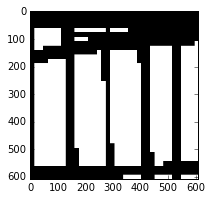

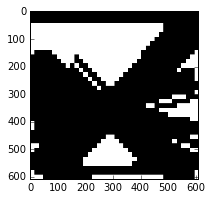

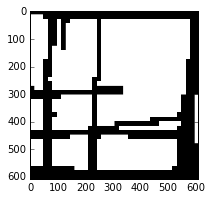

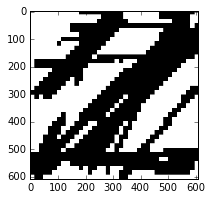

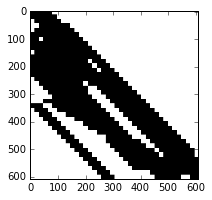

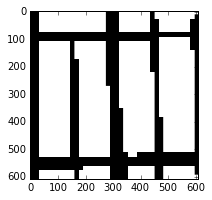

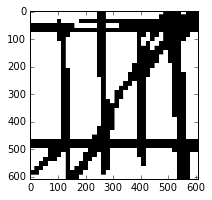

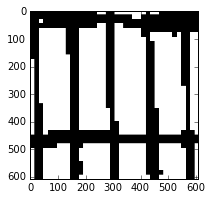

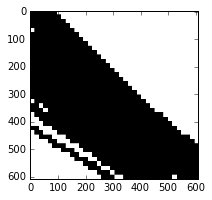

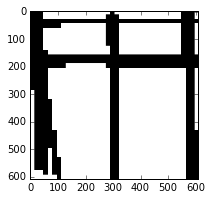

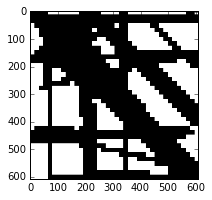

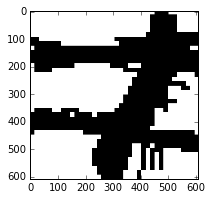

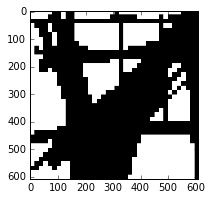

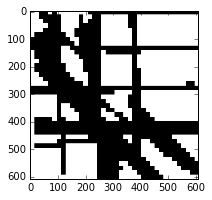

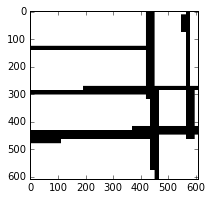

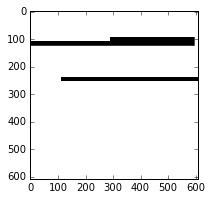

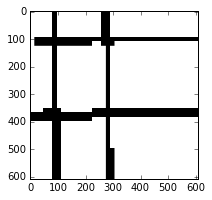

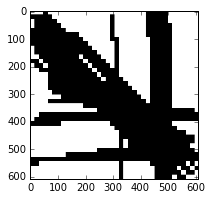

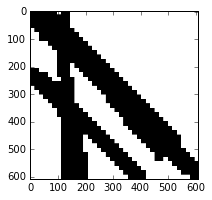

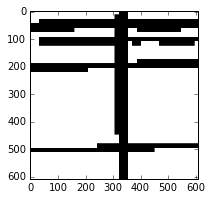

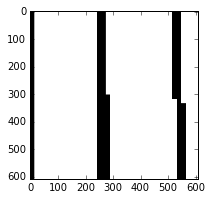

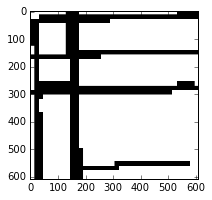

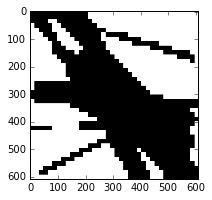

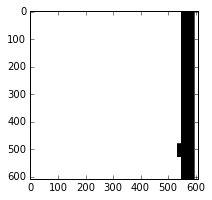

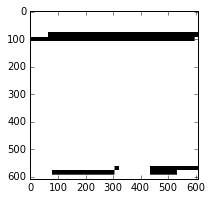

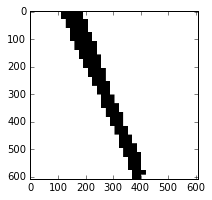

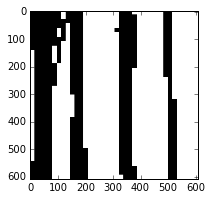

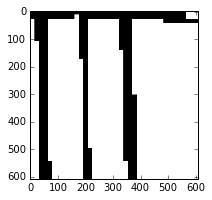

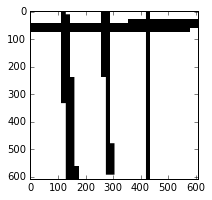

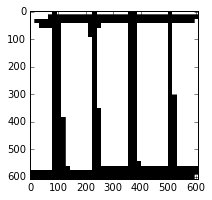

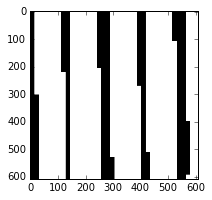

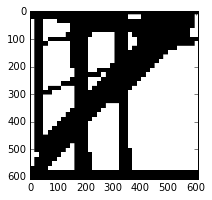

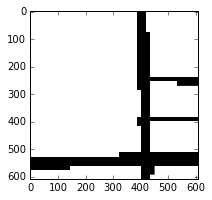

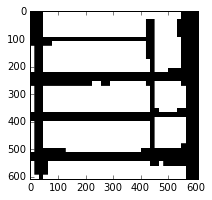

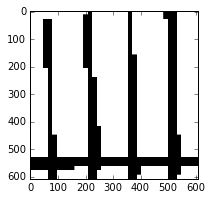

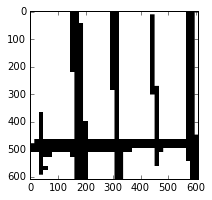

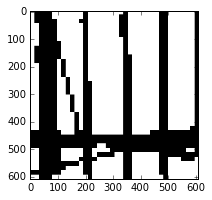

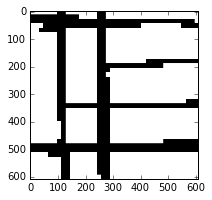

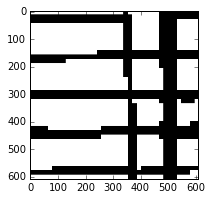

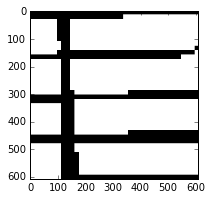

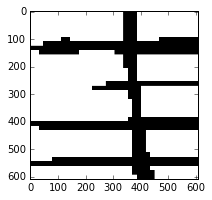

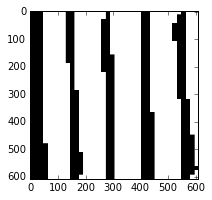

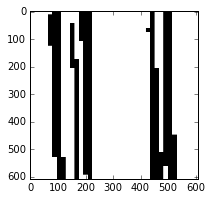

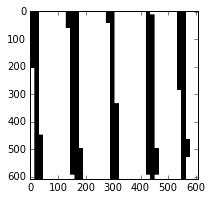

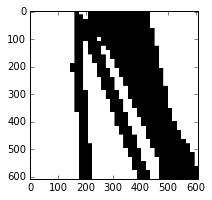

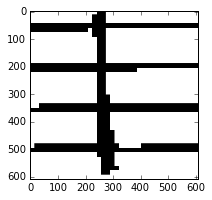

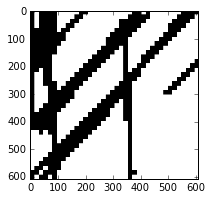

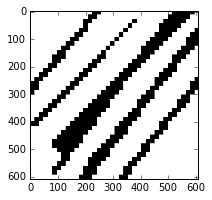

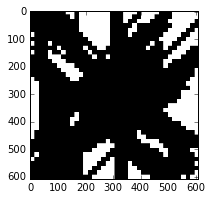

In [160]:
import os
import sys
from PIL import Image
import math
import matplotlib.image as mpimg
import numpy as np

label_file = 'data/dummy_submission.csv'

h = 16
w = h
imgwidth = int(math.ceil((600.0/w))*w)
imgheight = int(math.ceil((600.0/h))*h)
nc = 3

# Convert an array of binary labels to a uint8
def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def reconstruct_from_labels(image_id):
    im = np.zeros((imgwidth, imgheight), dtype=np.uint8)
    f = open(label_file)
    lines = f.readlines()
    image_id_str = '%.3d_' % image_id
    for i in range(1, len(lines)):
        line = lines[i]
        if not image_id_str in line:
            continue

        tokens = line.split(',')
        id = tokens[0]
        prediction = int(tokens[1])
        tokens = id.split('_')
        i = int(tokens[1])
        j = int(tokens[2])

        je = min(j+w, imgwidth)
        ie = min(i+h, imgheight)
        if prediction == 0:
            adata = np.zeros((w,h))
        else:
            adata = np.ones((w,h))

        im[j:je, i:ie] = binary_to_uint8(adata)

    Image.fromarray(im).save('prediction_' + '%.3d' % image_id + '.png')

    return im

for i in range(1, 50):
    plt.figure(figsize=(3, 3))
    plt.imshow(reconstruct_from_labels(i), cmap='Greys')

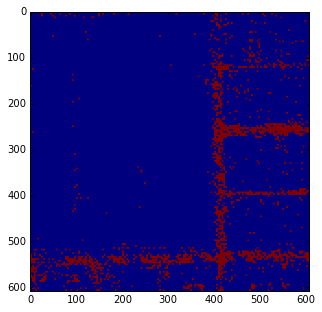

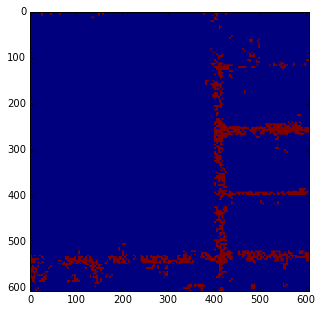

In [111]:
prediction_mask_filter = np.copy(prediction_mask)
plt.figure(figsize=(5, 5))
plt.imshow(prediction_mask)

window_size = 10
thresh = 0.3

for i in range (0,prediction_mask_filter.shape[0],window_size):
    for j in range (0,prediction_mask_filter.shape[1],window_size):
        sum_ = 0;
        for x in range (i,i+window_size):
            if (x >= prediction_mask_filter.shape[0]):
                break
            for y in range (j,j+window_size):
                if (y >= prediction_mask_filter.shape[1]):
                    break
                sum_ = sum_ + prediction_mask_filter[x,y]
        if (sum_/(window_size**2) < thresh):
            for x in range (i,i+window_size):
                if (x >= prediction_mask_filter.shape[0]):
                    break
                for y in range (j,j+window_size):
                    if (y >= prediction_mask_filter.shape[1]):
                        break
                    prediction_mask_filter[x,y] = 0

plt.figure(figsize=(5, 5))
plt.imshow(prediction_mask_filter)

In [9]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, downscale_local_mean, hough_line, hough_ellipse)
from skimage.feature import canny
from skimage import data
from sklearn.cluster import KMeans
from skimage.morphology import square

from skimage.morphology import erosion
from skimage.morphology import dilation
from skimage.transform import rotate

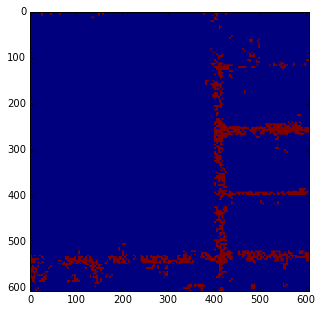

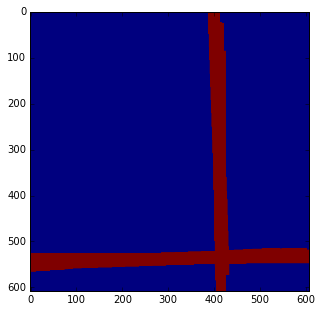

In [113]:
import warnings
warnings.filterwarnings('ignore')

image = rotate(prediction_mask_filter, 0)

lines = probabilistic_hough_line(image, threshold=210, line_length=70,
                                line_gap=100)

plt.figure(figsize=(5, 5))
plt.imshow(image)

img = np.zeros((608, 608), dtype=np.uint8)
for l in lines:
    ((x1, y1), (x2, y2)) = l
    rr, cc = line(x1, y1, x2, y2)
    img[cc, rr] = 1
    
eroted = dilation(img, square(12))

plt.figure(figsize=(5, 5))
plt.imshow(eroted)        